In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp
from scipy.sparse import save_npz, load_npz, csr_matrix
from scipy.spatial import distance_matrix
import networkx as nx

from net.utils import *
from net import utils_netgan as utils
import net.net as net

In [49]:
def main(A, H, steps, optimizer_args, log_every, print_every):
    # Remove isolated and pendant nodes because of assertion error 
    A = A.toarray()
    degrees = A.sum(axis=-1)
    A = A[degrees>1]
    A = A[:, degrees>1]
    A = sp.csr_matrix(A)
    
    # Split into train, test, and validation
    val_share = 0.1
    test_share = 0.05
    seed = 481516241
    train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(A,
                                                                                                  val_share,
                                                                                                  test_share,
                                                                                                  seed,
                                                                                                  undirected=True,
                                                                                                  connected=True,
                                                                                                  asserts=False)
    train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
    assert (train_graph.toarray() == train_graph.toarray().T).all()
    
    # Apply pipeline to generate a graph with our method
    H = H
    W = train_graph.toarray()
    W /= W.sum()

    netmodel = net.NetWithoutSampling(W=W, 
                                      H=H, 
                                      loggers=[net.GraphStatisticsLoggerWithoutSampling(train_graph, 
                                                                                        val_ones,
                                                                                        val_zeros,
                                                                                        log_every=log_every),
                                               net.OverlapLoggerWithoutSampling(train_graph, 
                                                                                print_every=print_every)])

    netmodel.train(steps=steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    statistics_logger = netmodel.loggers[0]
    return train_graph, sampled_graph, statistics_logger

# Test if graphs are in the correct format for pipeline

## 1) Cora-ML

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]

A = _A_obs
utils.compute_graph_statistics(A.toarray())

Selecting 1 largest connected components


{'d_max': 246.0,
 'd_min': 1.0,
 'd': 5.680427046263345,
 'LCC': 2810,
 'wedge_count': 137719.0,
 'claw_count': 3930163.0,
 'triangle_count': 5247,
 'square_count': 1897,
 'power_law_exp': 1.767268173251812,
 'gini': 0.49576150831534505,
 'rel_edge_distr_entropy': 0.9385266303817796,
 'assortativity': -0.0765923075115591,
 'clustering_coefficient': 0.0040051773934058205,
 'n_components': 1,
 'cpl': 5.271417621802822,
 'spectral_gap': 0.007356519149841935}

In [11]:
train_graph, sampled_graph, statistics_logger = main(A=A, H=12, steps=150,
                                                     optimizer_args={'lr' : 0.1},
                                                     log_every=5,
                                                     print_every=50)

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

Step: 49, Loss: 2.40412, Edge-Overlap: 0.762
Step: 99, Loss: 2.19579, Edge-Overlap: 0.886
Step: 149, Loss: 2.14844, Edge-Overlap: 0.927


## 2) CiteSeer

#### Change file to easily loadable npz format

In [117]:
# ## Save citeseer to easily loadable npz file
# reader = open('../data/citeseer/citeseer.edges')

# rows = []
# cols = []
# vals = []

# for line in reader:
#     r, c, v = line.split(",")
#     rows.append(int(r))
#     cols.append(int(c))
#     vals.append(int(v))

# rows = np.array(rows) - 1
# cols = np.array(cols) - 1
# vals = np.array(vals)

# max_node = max(max(rows), max(cols)) + 1
# citeseer = csr_matrix((vals, (rows, cols)), shape=(max_node, max_node))

# save_npz('../data/citeseer.npz', citeseer)
# citeseer

<3264x3264 sparse matrix of type '<class 'numpy.int64'>'
	with 4536 stored elements in Compressed Sparse Row format>

#### Load file from npz

In [7]:
_A_obs = load_npz('../data/citeseer.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]

A = _A_obs
utils.compute_graph_statistics(A.toarray())

Selecting 1 largest connected components


{'d_max': 99,
 'd_min': 1,
 'd': 3.476777251184834,
 'LCC': 2110,
 'wedge_count': 25943.0,
 'claw_count': 250348.0,
 'triangle_count': 1083,
 'square_count': 249,
 'power_law_exp': 2.0682375896415137,
 'gini': 0.4273119124282252,
 'rel_edge_distr_entropy': 0.9538630200773682,
 'assortativity': 0.0071366166694059536,
 'clustering_coefficient': 0.012977934714876892,
 'n_components': 1,
 'cpl': 9.310486989858404,
 'spectral_gap': 0.0015549386805810733}

Step: 24, Loss: 3.19899, Edge-Overlap: 0.306
Step: 49, Loss: 2.06285, Edge-Overlap: 0.652
Step: 74, Loss: 1.79019, Edge-Overlap: 0.767
Step: 99, Loss: 1.68849, Edge-Overlap: 0.819
Step: 124, Loss: 1.63901, Edge-Overlap: 0.849
Step: 149, Loss: 1.61047, Edge-Overlap: 0.873


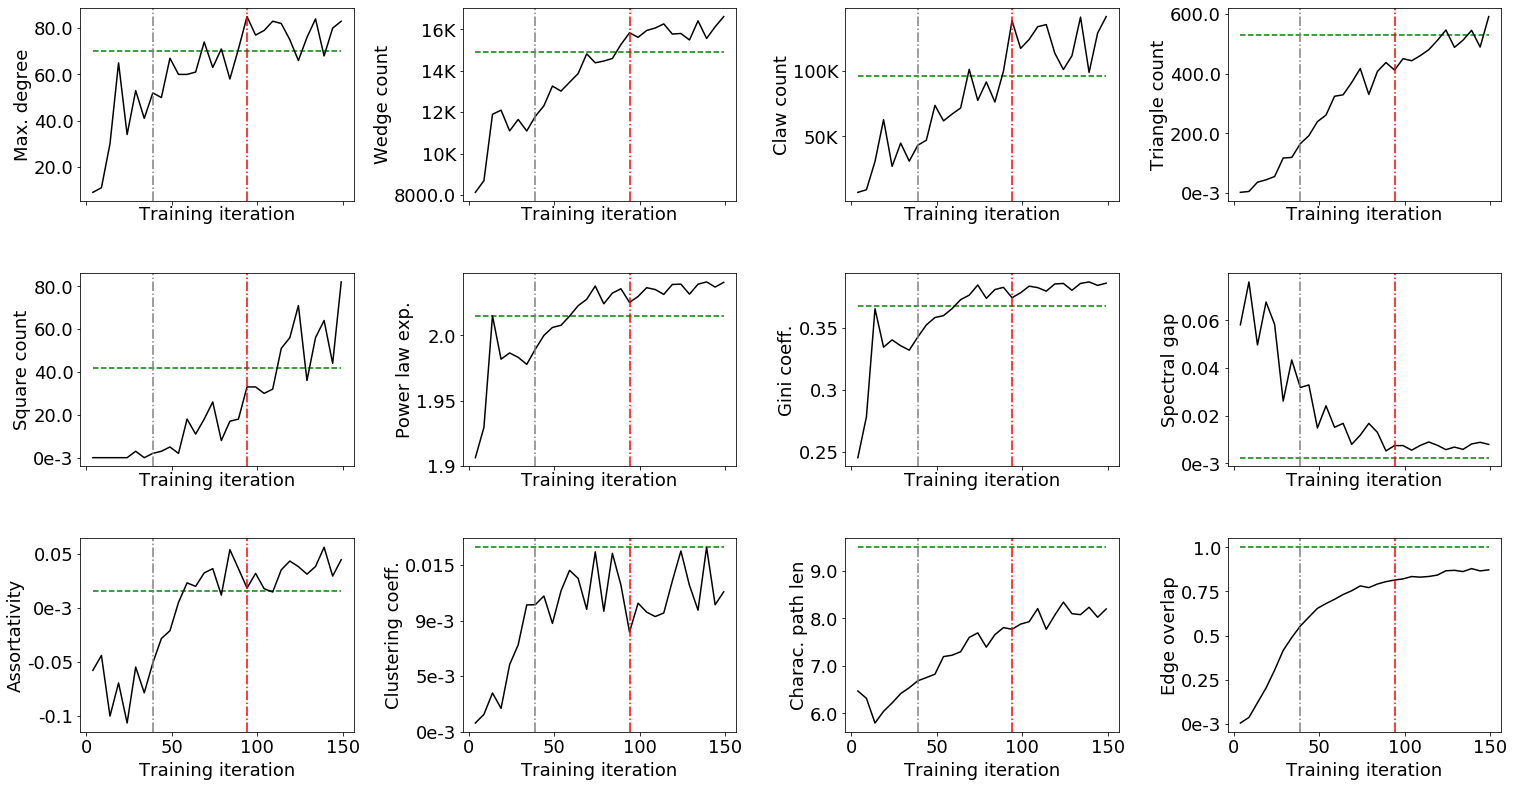

In [12]:
train_graph, sampled_graph, statistics_logger = main(A=A, H=7, steps=150,
                                                     optimizer_args={'lr' : 0.1},
                                                     log_every=5,
                                                     print_every=25)

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

# 3) Pol. blogs

#### Change file to easily loadable npz format

In [5]:
# ## Save to easily loadable npz file
# reader = open('../data/polblogs/polblogs.mtx')

# rows = []
# cols = []
# vals = []

# line_count = 0

# for line in reader:
#     if line_count<3:
#         print(line.rstrip())
#     else:
#         r, c, v = line.split(" ")
#         rows.append(int(r))
#         cols.append(int(c))
#         vals.append(int(v))
#     line_count += 1
            

# rows = np.array(rows) - 1
# cols = np.array(cols) - 1
# vals = np.array(vals)

# max_node = max(max(rows), max(cols)) + 1
# polblogs = csr_matrix((vals, (rows, cols)), shape=(max_node, max_node))

# save_npz('../data/polblogs.npz', polblogs)
# polblogs

%%MatrixMarket matrix coordinate integer general
% kind: directed multigraph
1490 1490 19025


<1490x1490 sparse matrix of type '<class 'numpy.int64'>'
	with 19025 stored elements in Compressed Sparse Row format>

#### Load file from npz

In [22]:
_A_obs = load_npz('../data/polblogs.npz')
_A_obs.setdiag(0)
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]

A = _A_obs
utils.compute_graph_statistics(A.toarray())

Selecting 1 largest connected components


{'d_max': 351,
 'd_min': 1,
 'd': 27.355155482815057,
 'LCC': 1222,
 'wedge_count': 1341525.0,
 'claw_count': 62800777.0,
 'triangle_count': 101043,
 'square_count': 422327,
 'power_law_exp': 1.4142735792265944,
 'gini': 0.6203828753182206,
 'rel_edge_distr_entropy': 0.9026537457335121,
 'assortativity': -0.2213287230119227,
 'clustering_coefficient': 0.004826835183902263,
 'n_components': 1,
 'cpl': 2.7375296736998864,
 'spectral_gap': 0.08143977933586617}

Step: 24, Loss: 5.22044, Edge-Overlap: 0.363
Step: 49, Loss: 5.00719, Edge-Overlap: 0.405
Step: 74, Loss: 4.93837, Edge-Overlap: 0.427
Step: 99, Loss: 4.90271, Edge-Overlap: 0.436
Step: 124, Loss: 4.88036, Edge-Overlap: 0.444
Step: 149, Loss: 4.86521, Edge-Overlap: 0.448


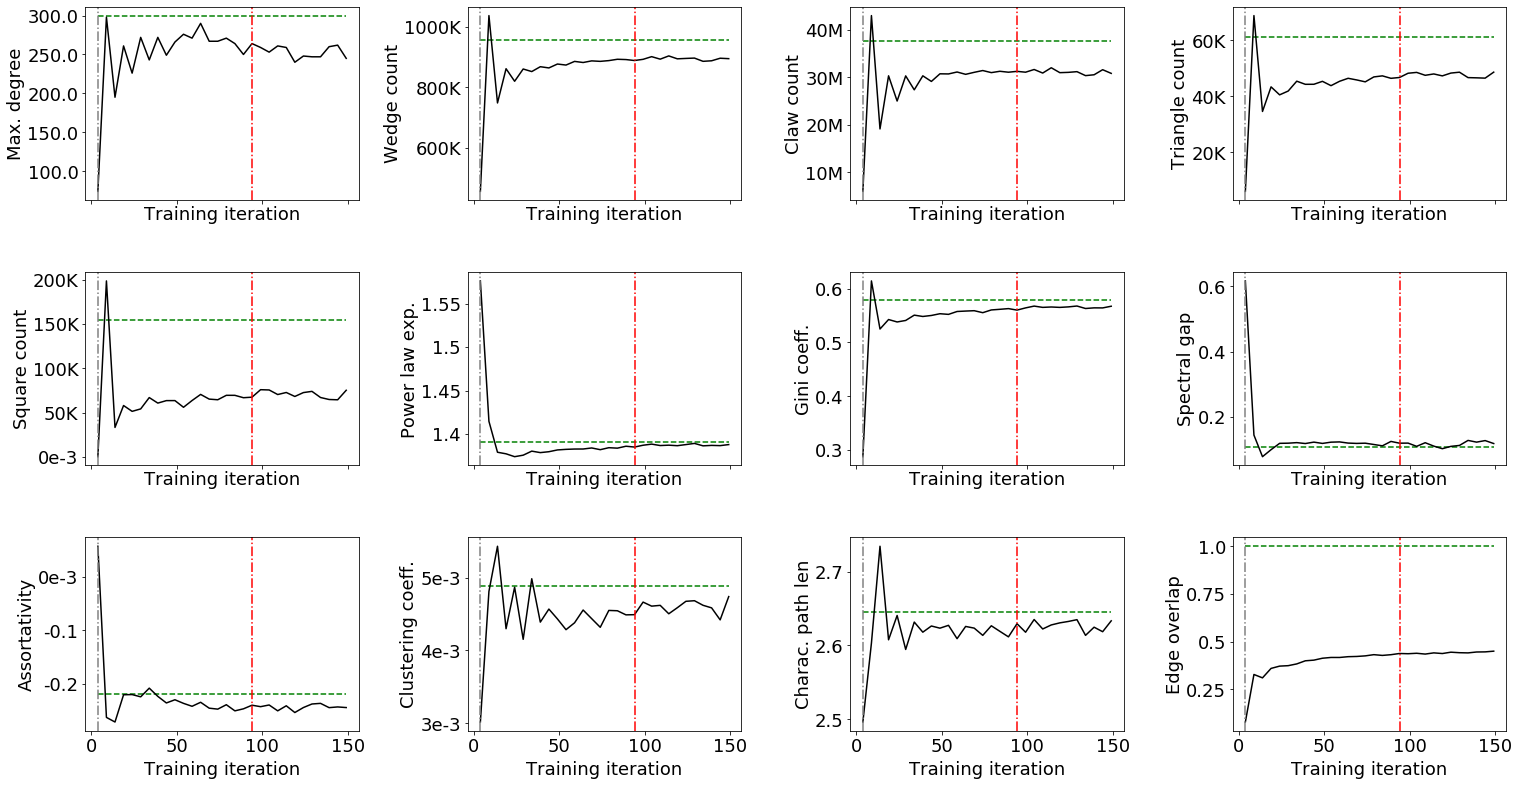

In [50]:
train_graph, sampled_graph, statistics_logger = main(A=A, H=12, steps=150,
                                                     optimizer_args={'lr' : 0.1},
                                                     log_every=5,
                                                     print_every=25)

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

## 4) Higgs

#### Change file to easily loadable npz format

In [60]:
## Save Higgs to easily loadable npz file
reader = open('../data/rt-higgs/rt-higgs.edges')

rows = []
cols = []
vals = []

for line in reader:
    r, c, v = line.split(" ")
    if int(r)>0 and int(c)>0 and int(v)==1:
        rows.append(int(r))
        cols.append(int(c))
        vals.append(int(v))

rows = np.array(rows) - 1
cols = np.array(cols) - 1
vals = np.array(vals)

max_node = max(max(rows), max(cols)) + 1
higgs = csr_matrix((vals, (rows, cols)), shape=(max_node, max_node))

save_npz('../data/higgs.npz', higgs)
higgs

<456629x456629 sparse matrix of type '<class 'numpy.int64'>'
	with 711522 stored elements in Compressed Sparse Row format>

#### Load file from npz

In [ ]:
_A_obs = load_npz('../data/higgs.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs.setdiag(0)
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]

A = _A_obs
utils.compute_graph_statistics(A.toarray())

Selecting 1 largest connected components


Step: 24, Loss: 3.19899, Edge-Overlap: 0.306
Step: 49, Loss: 2.06285, Edge-Overlap: 0.652
Step: 74, Loss: 1.79019, Edge-Overlap: 0.767
Step: 99, Loss: 1.68849, Edge-Overlap: 0.819
Step: 124, Loss: 1.63901, Edge-Overlap: 0.849
Step: 149, Loss: 1.61047, Edge-Overlap: 0.873


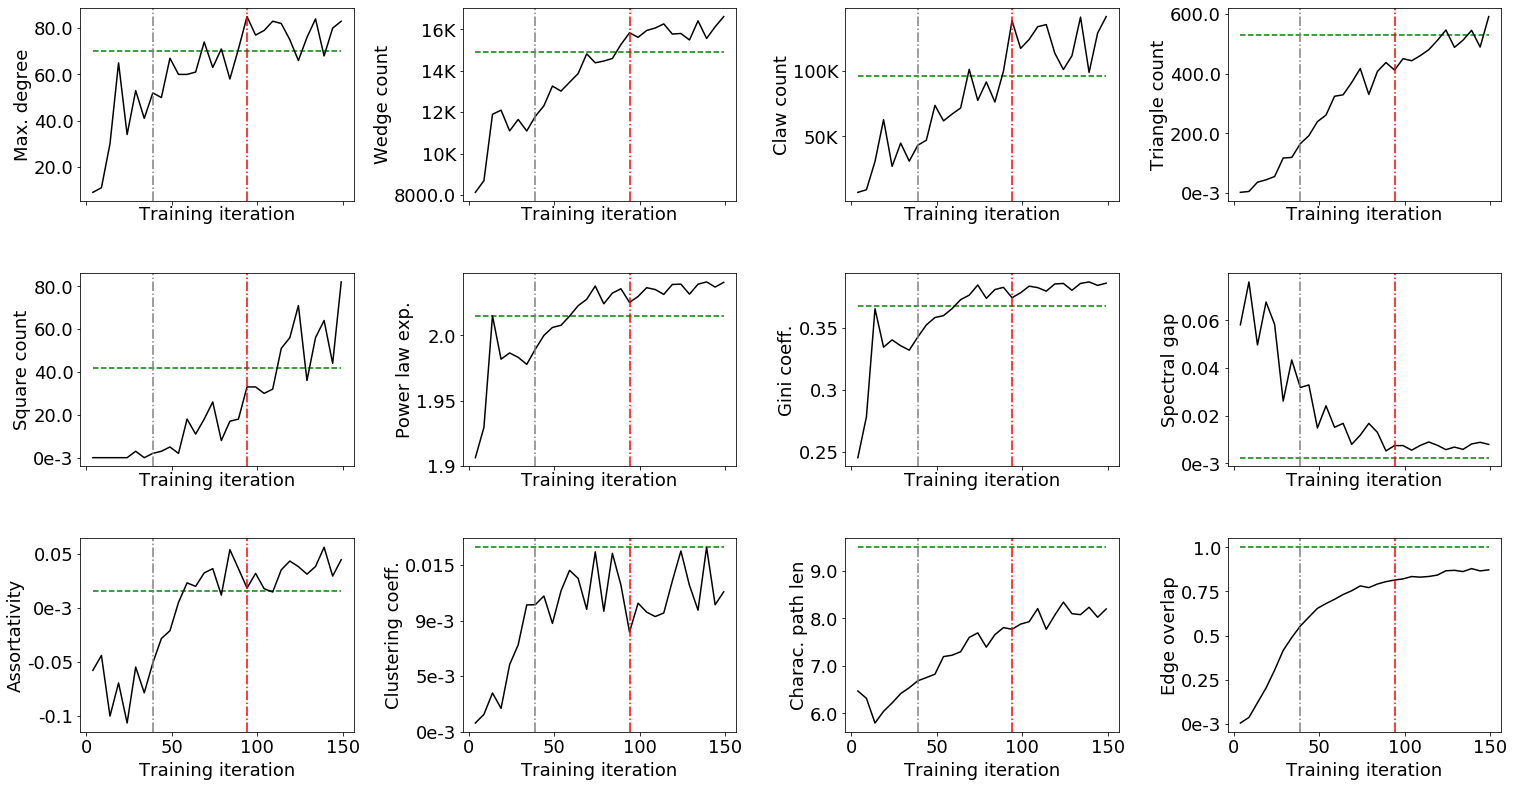

In [12]:
train_graph, sampled_graph, statistics_logger = main(A=A, H=7, steps=150,
                                                     optimizer_args={'lr' : 0.1},
                                                     log_every=5,
                                                     print_every=25)

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

# 5) soc-gemsec-HU

In [8]:
## Save to easily loadable npz file
reader = open('../data/soc-gemsec-HU/soc-gemsec-HU.edges')

rows = []
cols = []
vals = []

line_count = 0

for line in reader:
        r, c = line.split(",")
        rows.append(int(r))
        cols.append(int(c))
        vals.append(1)
            

rows = np.array(rows)
cols = np.array(cols)
vals = np.array(vals)

max_node = max(max(rows), max(cols)) + 1
gemsec = csr_matrix((vals, (rows, cols)), shape=(max_node, max_node))

save_npz('../data/gemsec.npz', gemsec)
gemsec

ValueError: negative row index found